**Description**: Histograms and p-values for each dataset.

**Estimated runtime**: ~10 sec.

In [1]:
import os
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.stats import permutation_test
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which model and which number of test observations do you want to analyze?

In [3]:
model: Literal["bert", "gpt2"] = "bert"
num_test: Literal[200, 500] = 200

# Load data

In [4]:
accuracies_dir = os.path.join("accuracies_from_paper", str(num_test), model)
accuracy_df = utils.load_accuracies(accuracies_dir)

# Analysis

Below are the distributions of $\text{acc}_{\text{base}}$, $\text{acc}_{\text{extra}}$,
and $\text{acc}_{\text{test}}$, and the p-value corresponding to the following
statistical test:

$$
\begin{align*}
H_0&: \text{E}[\text{acc}_{\text{test}} - \text{acc}_{\text{extra}}] = 0 \\
H_1&: \text{E}[\text{acc}_{\text{test}} - \text{acc}_{\text{extra}}] > 0.
\end{align*}
$$

The p-value is estimated via permutation testing. It's then adjusted to control the
false discovery rate.

In [5]:
def _plot_histograms(
    dataset: str,
    df: pl.DataFrame,
    num_classes: int,
    majority_accuracy: float,
    bins: int | str = 10,
    show_majority_accuracy_legend: bool = False,
):
    fig, axes = plt.subplots(
        nrows=len(df.columns), ncols=1, figsize=(6, len(df.columns) * 1.5)
    )
    axes: list[plt.Axes]
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    ylim = (0, 20)
    # Plot histograms for each column
    for i, column in enumerate(df.columns):
        ax = axes[i]
        ax.hist(df.get_column(column), bins=bins, range=(0, 1), color=colors[i])
        ax.set_ylim(ylim)
        ax.set_xlabel(f"$\\text{{acc}}_\\text{{{column}}}$")
        ax.set_ylabel("frequency")
        if show_majority_accuracy_legend:
            # Option 3 from here: https://stackoverflow.com/a/4701285/18758987
            vline_label = "majority accuracy" if i == len(df.columns) - 1 else None
        else:
            vline_label = None
        ax.axvline(majority_accuracy, *ylim, label=vline_label, color="k")
        if show_majority_accuracy_legend:
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    if show_majority_accuracy_legend:
        fig.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig.suptitle(f"Dataset: {dataset}, # classes = {num_classes}", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(hspace=1.2)

In [6]:
def individual_analysis(
    dataset: str, df: pl.DataFrame, num_classes: int, majority_accuracy: float
) -> float:
    p_value: float = permutation_test(
        data=(df["test"], df["extra"]),
        statistic=lambda x, y: np.mean(x - y),
        alternative="greater",  # acc_test > acc_extra
        permutation_type="samples",  # paired observations
        n_resamples=10_000,
    ).pvalue
    # print(f"p-value: {p_value}")
    # print()

    _plot_histograms(dataset, df, num_classes, majority_accuracy)

    return p_value

In [7]:
def analyze_all_separately(accuracy_df: pl.DataFrame) -> list[float]:
    return [
        individual_analysis(
            dataset,
            df.select(["base", "extra", "test"]),
            df["num_classes"][0],
            df["majority"][0],
        )
        for dataset, df in accuracy_df.group_by("dataset", maintain_order=True)
    ]

Black vertical line is majority accuracy

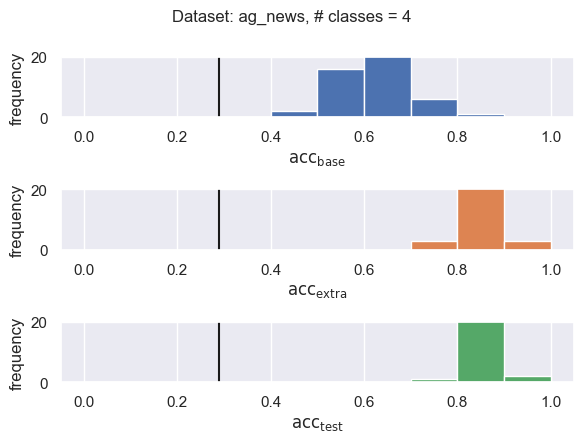

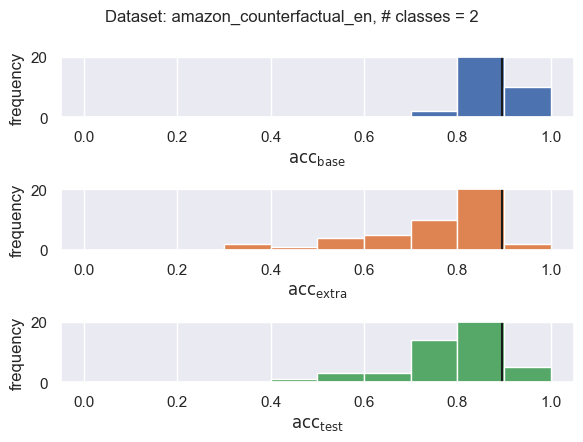

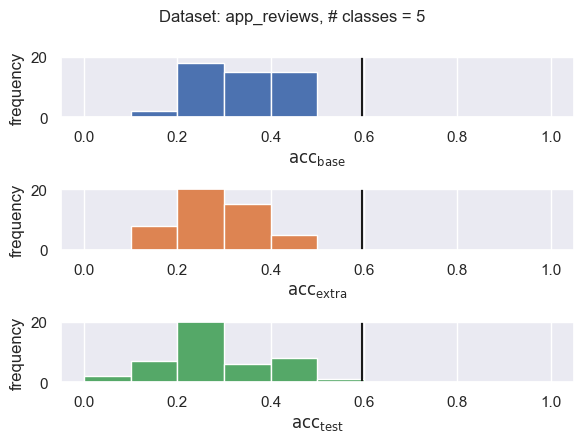

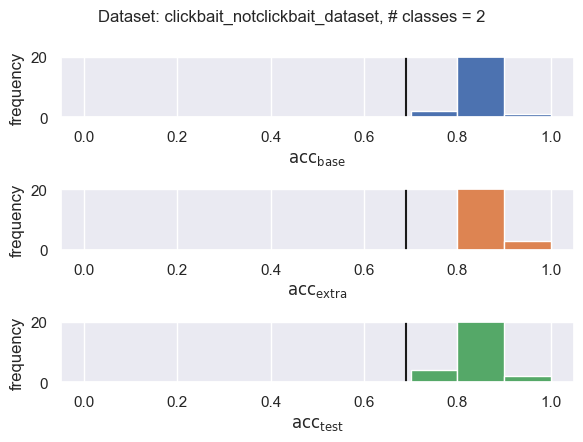

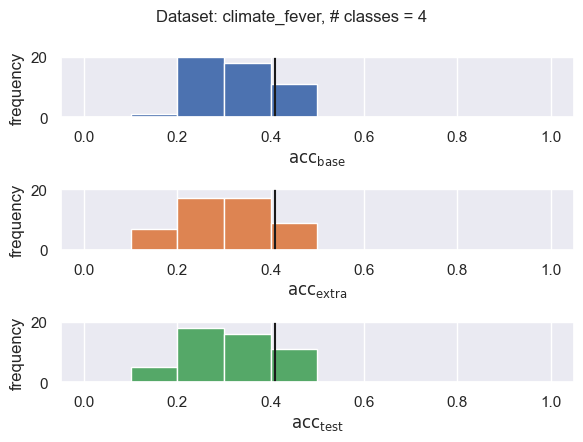

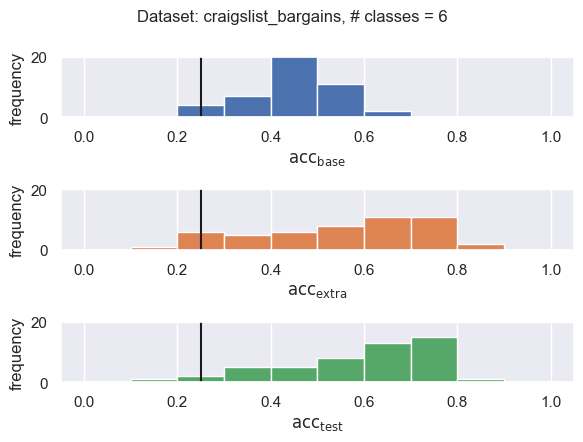

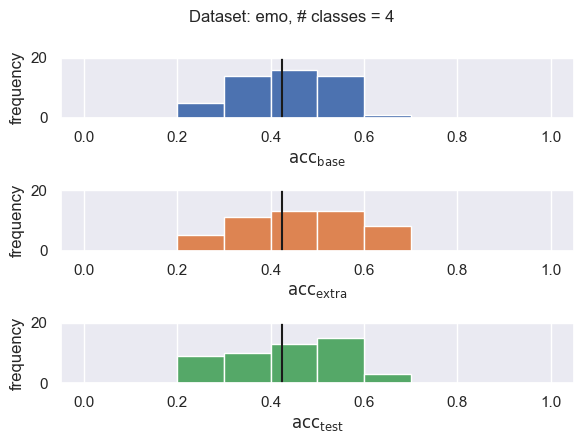

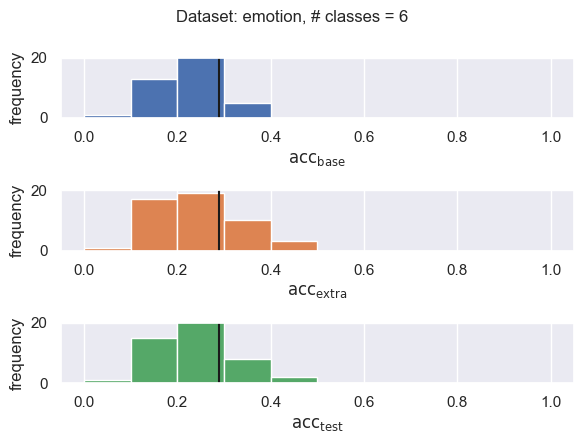

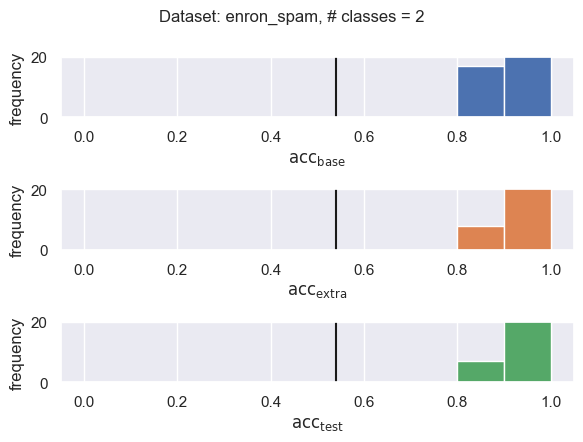

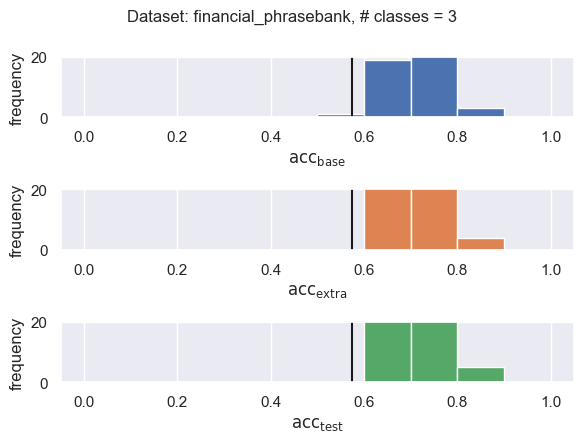

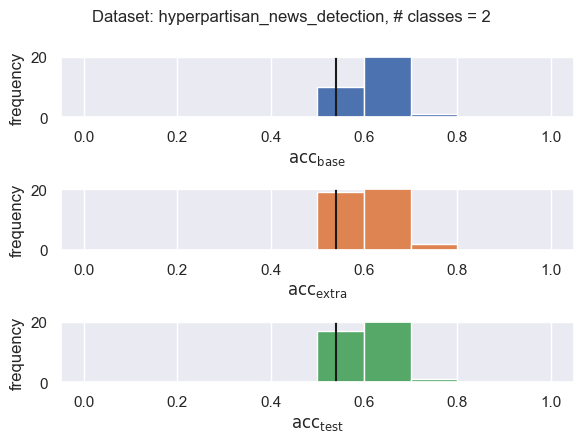

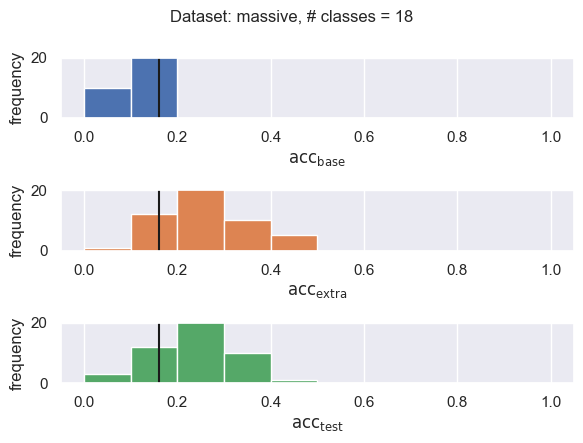

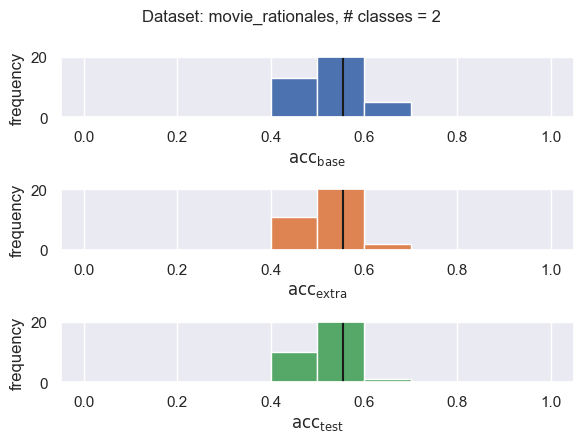

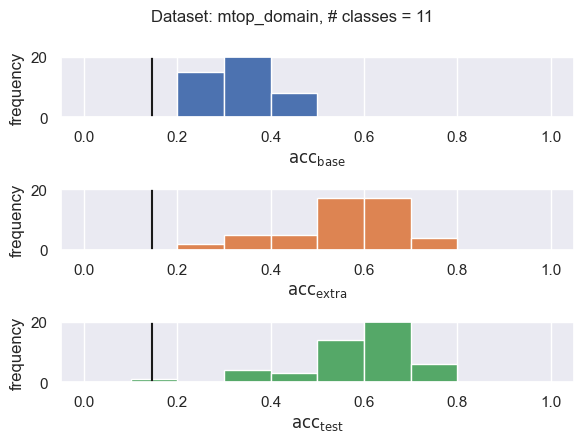

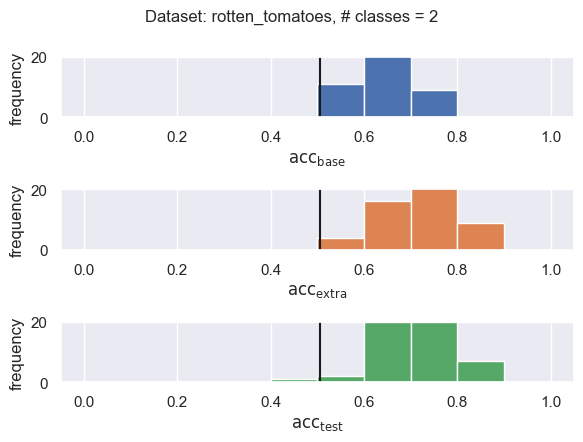

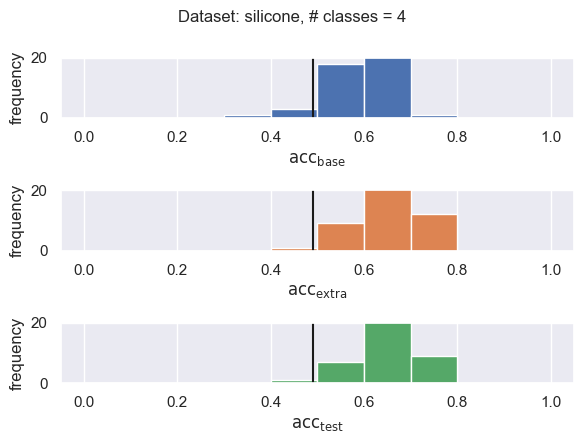

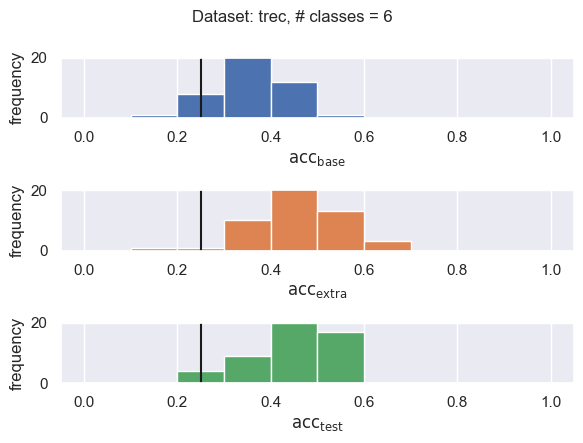

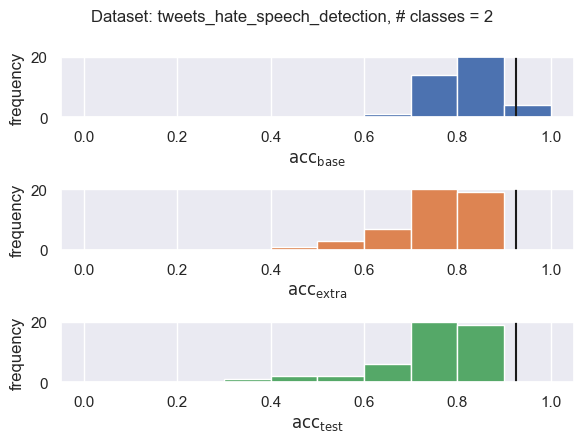

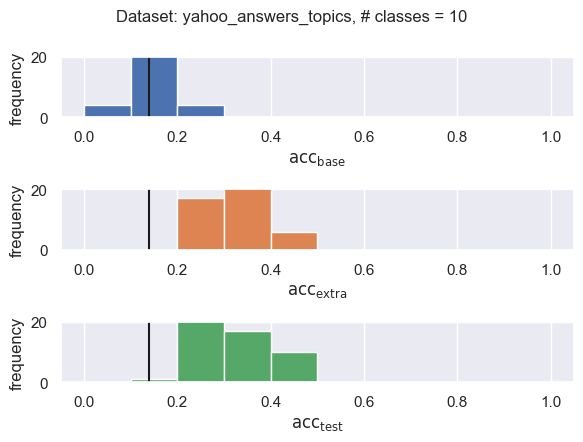

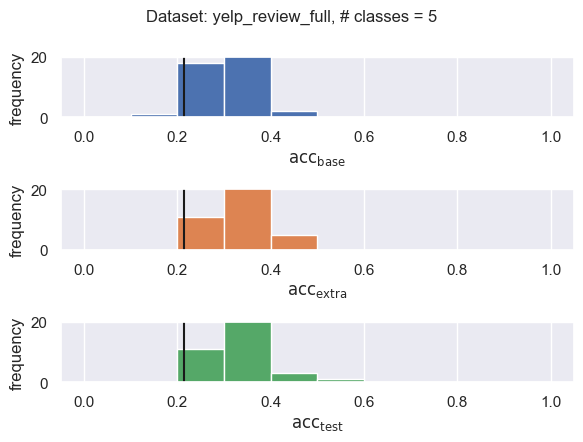

In [8]:
p_values = analyze_all_separately(accuracy_df)

In [9]:
p_values_adjusted = pl.DataFrame(
    {
        "dataset": accuracy_df["dataset"].unique(maintain_order=True),
        "p-value": fdrcorrection(p_values)[1],
    }
)
pl.Config.set_fmt_str_lengths(200)
p_values_adjusted.with_columns(pl.col("p-value").round(3))

dataset,p-value
str,f64
"""ag_news""",0.545
"""amazon_counterfactual_en""",0.545
"""app_reviews""",0.87
"""clickbait_notclickbait_dataset""",0.87
"""climate_fever""",0.668
"""craigslist_bargains""",0.545
"""emo""",0.901
"""emotion""",0.87
"""enron_spam""",0.958


Note: after adjustment, it's wrong to interpret 1 - p the same way we would an
unadjusted p-value.